In [47]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import math
from glob import glob
import os

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import cv2
from itertools import product
from numpy import dot, exp, mgrid, pi, ravel, square, uint8, zeros, pad

import pandas as pd
import sys

import seaborn as sn

import warnings
warnings.filterwarnings("ignore")


# 1. PREPROCESING

In [298]:
## Step1: Guassian Filter:

def gen_gaussian_kernel(k_size, sigma):
    center = k_size // 2
    x, y = mgrid[0 - center : k_size - center, 0 - center : k_size - center]
    g = 1 / (2 * pi * sigma) * exp(-(square(x) + square(y)) / (2 * square(sigma)))
    return g


def gaussian_filter(image, k_size, sigma):
    height, width = image.shape[0], image.shape[1]

    dst_height = height - k_size + 1
    dst_width = width - k_size + 1

    image_array = zeros((dst_height * dst_width, k_size * k_size))
    row = 0
    for i, j in product(range(dst_height), range(dst_width)):
        window = ravel(image[i : i + k_size, j : j + k_size])
        image_array[row, :] = window
        row += 1

    gaussian_kernel = gen_gaussian_kernel(k_size, sigma)
    filter_array = ravel(gaussian_kernel)

    dst = dot(image_array, filter_array).reshape(dst_height, dst_width).astype(uint8)

    return dst

## Step2: Sobel Filter X for vertical edges

def Sobel(img):
    container = np.copy(img)
    size = container.shape
    for i in range(1, size[0] - 1):
        for j in range(1, size[1] - 1):
            gx = (img[i - 1][j - 1] + 2*img[i][j - 1] + img[i + 1][j - 1]) - (img[i - 1][j + 1] + 2*img[i][j + 1] + img[i + 1][j + 1])
            gy = (img[i - 1][j - 1] + 2*img[i - 1][j] + img[i - 1][j + 1]) - (img[i + 1][j - 1] + 2*img[i + 1][j] + img[i + 1][j + 1])
            #container[i][j] = min(255, np.sqrt(gx**2 + gy**2))
            container[i][j] = min(255, np.abs(gx))
    return container
    pass

## Step3: OTSU + Binary Thresholding

def get_probabilities(histogram, u, num_pixels):
    """
    Compute the probabilities for Otsu thresholding.
    :histogram: the image histogram.
    :u: the pixel value.
    :num_pixels: the total number of pixels.
    """

    probability = 0

    # Get the sum.
    for i in range(0, u + 1):
        probability += histogram[i]

    # Get the probability.
    probability = probability / num_pixels

    return probability


def get_class_means(histogram, u, num_pixels):
    """
    Compute the class means for Otsu thresholding.
    :histogram: the image histogram.
    :u: the pixel value.
    :num_pixels: the total number of pixels.
    """

    mu_1 = 0
    mu_2 = 0

    # Get the probabilities
    P = get_probabilities(histogram, u, num_pixels)

    # Handle problems with division.
    if P == 0:
        return 0, 1
    if P == 1:
        return 1, 0

    # Get the means.
    for i in range(0, u + 1):
        mu_1 += i * histogram[i] / P
    for i in range(u, 256):
        mu_2 += i * histogram[i] / (1 - P)

    return mu_1, mu_2


def otsu_threshold(img):
    """
    Perform Otsu thresholding.
    :img: the original grayscale image.
    """

    num_pixels = img.shape[0] * img.shape[1]

    increment = 1
    u = increment
    threshold = u
    S_max = 0

    while u < 256:

        # Compute the probabilities and means.
        c_I = get_probabilities(histogram, u, num_pixels)
        mu_1, mu_2 = get_class_means(histogram, u, num_pixels)

        # Compute the variance.
        sigma_b = (c_I) * (1 - c_I) * (mu_1 - mu_2) ** 2

        # Update the threshold.
        if sigma_b > S_max:
            S_max = sigma_b
            threshold = u

        # Go to the next pixel.
        u += increment

    # Flatten the image.
    flat = np.ndarray.flatten(img)

    # Perform the threshold.
    for i in range(flat.shape[0]):

        if (flat[i]) > threshold:  # Anterior (flat[i]*255) > threshold porque flat[i] era del rango de 0 a 1.
            flat[i] = 255
        else:
            flat[i] = 0

    # Reshape the image.
    thresh_img = np.reshape(flat, (img.shape[0], img.shape[1]))
  
    return thresh_img

## Step4: Closing-Opening Operation:

# Elemento estructurante
B_pos_3x3 = np.matrix('-1 -1; 0 -1; 1 -1;-1 0;0 0; 1 0;-1 1; 0 1; 1 1')
B_pos_5x5 = np.matrix('-2 -2;-2 -1;-2  0;-2 1;-2 2;-1 -2;-1 -1;-1 0;-1 1;-1 2;0 -2;0 -1;0 0;0 1;0 2;1 -2;1 -1;1 0;1 1;1 2;2 -2;2 -1;2 0;2 1;2 2') 
B_pos_7x7 = np.matrix('-3 -3;-3 -2;-3  -1;-3 0;-3 1;-3 2;-3 3;-2 -3;-2 -2;-2 -1;-2 0;-2 1;-2 2;-2 3;-1 -3;-1 -2;-1 -1;-1 0;-1 1;-1 2;-1 3;0 -3; 0 -2;0 -1;0 0;0 1;0 2;0 3;1 -3; 1 -2;1 -1;1 0;1 1;1 2;1 3;2 -3; 2 -2;2 -1;2 0;2 1;2 2;2 3;3 -3;3 -2;3 -1;3 0;3 1;3 2;3 3') 
B_pos_9x9 = np.matrix('-4 -4;-4 -3;-4 -2;-4 -1;-4 0;-4 1;-4 2;-4 3;-4 4;-3 -4;-3 -3;-3 -2;-3 -1;-3 0;-3 1;-3 2;-3 3;-3 4;-2 -4;-2 -3;-2 -2;-2 -1;-2 0;-2 1;-2 2;-2 3;-2 4;-1 -4;-1 -3;-1 -2;-1 -1;-1 0;-1 1;-1 2;-1 3;-1 4;0 -4; 0 -3; 0 -2; 0 -1; 0 0; 0 1; 0 2; 0 3; 0 4;1 -4; 1 -3; 1 -2; 1 -1; 1 0; 1 1; 1 2; 1 3; 1 4;2 -4; 2 -3; 2 -2; 2 -1; 2 0; 2 1; 2 2; 2 3; 2 4;3 -4; 3 -3; 3 -2; 3 -1; 3 0; 3 1; 3 2; 3 3; 3 4;4 -4; 4 -3; 4 -2; 4 -1; 4 0; 4 1; 4 2; 4 3; 4 4') 

# Generator of Estructural Element
def B_nxm(n,m):
    """
    n = 3,5,7,...
    m = 3,5,7,...
    """
    n=int((n+1)/2)
    m=int((m+1)/2)
    list =[]
    for i in range(-(n-1),m):
        for j in range(-(n-1),m):
            list.append([i,j])
    return np.matrix(list)
        
    
def Erosion(A,B):
    i_g_Erotion = np.zeros([A.shape[0],A.shape[1]])
    # El range(i, A.shape[0]-i), i esta relacionado al rows
    # El range(j, A.shape[0]-j), j esta relacionado al cols
    
    row_lim = int((np.sqrt(B.shape[0])+1)/2)
    #col_lim = B.shape[1]//2
    
    for i in range(row_lim,A.shape[0]-row_lim):
        for j in range(row_lim,A.shape[1]-row_lim):
            vecinos = np.array(B[:,:]  + [i,j])
            min = 999
            for k in range(0,vecinos.shape[0]):
                if (k==0):
                    min = A[vecinos[k,0],vecinos[k,1]]
                if (min >= A[vecinos[k,0],vecinos[k,1]]):
                    min = A[vecinos[k,0],vecinos[k,1]]
            i_g_Erotion[i,j] = np.uint8(min)
    return i_g_Erotion


def Dilatacion(A,B):

    i_g_Dilation = np.zeros([A.shape[0],A.shape[1]])
  
    # El range(i, A.shape[0]-i), i esta relacionado al rows
    # El range(j, A.shape[0]-j), j esta relacionado al cols
    row_lim = int((np.sqrt(B.shape[0])+1)/2)
    #col_lim = B.shape[1]//2
    
    for i in range(row_lim,A.shape[0]-row_lim):
        for j in range(row_lim,A.shape[1]-row_lim):
            vecinos = np.array(B[:,:]  + [i,j])
            max = 0
            for k in range(0,vecinos.shape[0]):
                if (k==0):
                    max = A[vecinos[k,0],vecinos[k,1]]
                if (max <= A[vecinos[k,0],vecinos[k,1]]):
                    max = A[vecinos[k,0],vecinos[k,1]]
                #print(max)
            i_g_Dilation[i,j] = np.uint8(max)
    return i_g_Dilation

def Opening(A,B):
    i_g = Erosion(A, B) 
    i_g_1 = Dilatacion(i_g, B)
    return i_g_1

def Closing(A,B):
    i_g = Dilatacion(A, B) 
    i_g_1 = Erosion(i_g, B)
    return i_g_1


Tamño de la image:  (240, 352)


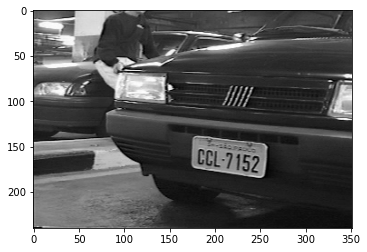

In [486]:
img1 = imageio.imread('placa6.png')
print("Tamño de la image: ", img1.shape)
plt.imshow(img1, cmap="gray")
plt.show()

Tamño de la image:  (234, 346)


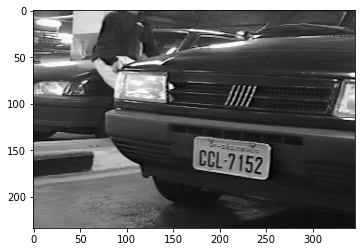

In [512]:
# Step1: Gaussian filter:

sigma = 1/(2*pi)
img_gaussian = gaussian_filter(img1, 7, sigma)
print("Tamño de la image: ", img_gaussian.shape)
plt.imshow(img_gaussian, cmap="gray")
plt.show()

Tamño de la image:  (234, 346)


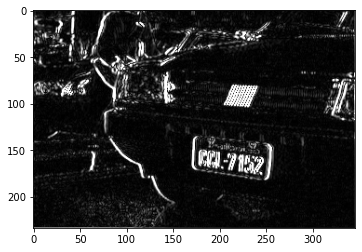

In [513]:
# Step2: Sobel filter:

img_sobel = Sobel(img_gaussian)
print("Tamño de la image: ", img_sobel.shape)
plt.imshow(img_sobel, cmap="gray")
plt.show()

Tamño de la image:  (234, 346)


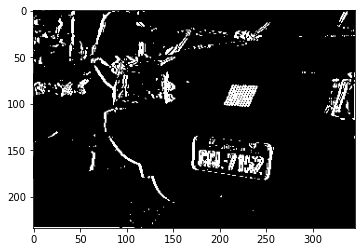

In [514]:
# Step3: Adaptive OTSU+Binary Thresholding:

histogram, bin_edges = np.histogram(img_sobel, bins=256, range=(0, 256))

# Perform Otsu thresholding.
img_otsu = otsu_threshold(img_sobel)

# Show the thresholded image.
print("Tamño de la image: ", img_otsu.shape)
plt.imshow(img_otsu, cmap='gray')
plt.show()

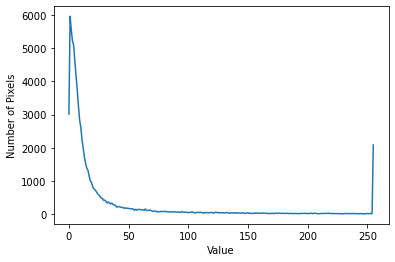

In [515]:
# Show the histogram.
plt.figure()
plt.xlabel("Value")
plt.ylabel("Number of Pixels")
#plt.xlim([0.0, 255.0])
plt.plot(bin_edges[0:-1], histogram)
plt.show()

(169, 2)
Tamño de la image:  (234, 346)


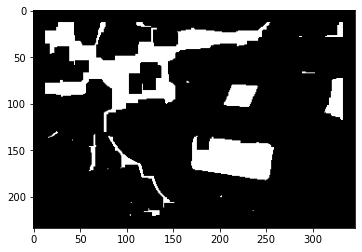

In [520]:
# Step4: Closing operation:
B = B_nxm(13,13)

print(B.shape)
img_close = Closing(img_otsu , B)

print("Tamño de la image: ", img_close.shape)
plt.imshow(img_close, cmap="gray")
plt.show()

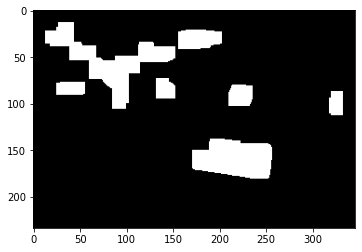

In [521]:
# Step5: Opening operation:
output = Erosion(img_close , B)
output = Dilatacion(output , B)
plt.imshow(output, cmap="gray")
plt.show()

In [575]:
    
img = imageio.imread('placa9.png')
print("Tamño de la image Original: ", img.shape)

# Step1: Gaussian filter:
sigma = 1/(2*pi)
img_gaussian = gaussian_filter(img, 7, sigma)
print("Tamño de la image con filtro Gausiano Pasa bajo: ", img_gaussian.shape)

# Step2: Sobel filter:
img_sobel = Sobel(img_gaussian)
print("Tamño de la image con filtro sobel X: ", img_sobel.shape)

# Step3: Adaptive OTSU+Binary Thresholding:
histogram, bin_edges = np.histogram(img_sobel, bins=256, range=(0, 256))
# Perform Otsu thresholding.
img_otsu = otsu_threshold(img_sobel)
print("Tamño de la image con Threshold OTSU: ", img_otsu.shape)

# Step4: Closing operation:
B = B_nxm(13,13)
#print(B.shape)
img_close = Closing(img_otsu , B)
print("Tamño de la image despues del Closing: ", img_close.shape)

# Step5: Final image
output = Erosion(img_close , B)
img_final = Dilatacion(output , B)
print("Tamño de la image final: ", img_close.shape)


Tamño de la image Original:  (240, 352)
Tamño de la image con filtro Gausiano Pasa bajo:  (234, 346)
Tamño de la image con filtro sobel X:  (234, 346)
Tamño de la image con Threshold OTSU:  (234, 346)
Tamño de la image despues del Closing:  (234, 346)
Tamño de la image final:  (234, 346)


In [554]:
plt.rcParams["figure.figsize"] = [7.00, 7]
plt.rcParams["figure.autolayout"] = True


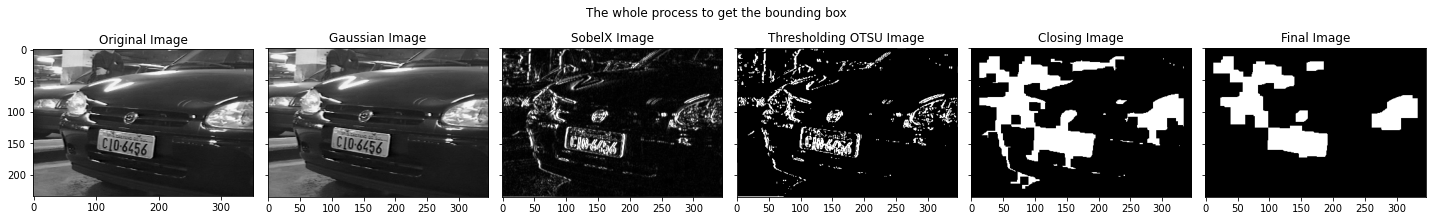

In [559]:
    
#Create two subplots and unpack the output array immediately
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, sharey=True, figsize=(20, 3))
f.suptitle('The whole process to get the bounding box')
ax1.imshow(img, cmap="gray")
ax1.set_title('Original Image')
ax2.imshow(img_gaussian, cmap="gray")
ax2.set_title('Gaussian Image')
ax3.imshow(img_sobel, cmap="gray")
ax3.set_title('SobelX Image')
ax4.imshow(img_otsu, cmap="gray")
ax4.set_title('Thresholding OTSU Image')
ax5.imshow(img_close, cmap="gray")
ax5.set_title('Closing Image')
ax6.imshow(img_final, cmap="gray")
ax6.set_title('Final Image')

#plt.imshow(img1_gray, cmap="gray") # cmap: color mapping
plt.show()


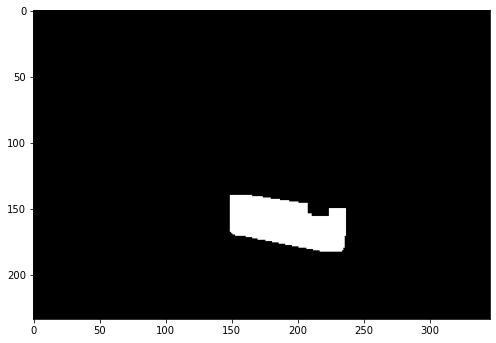

In [582]:
# Imagen Mascara Final de una imagen

for i in range(img_final.shape[0]//2):
    for j in range(img_final.shape[1]):
        img_final[i][j] = 0

plt.imshow(img_final, cmap="gray")    

Tamño de la image Original:  (240, 352)
Tamño de la image con filtro Gausiano Pasa bajo:  (234, 346)
Tamño de la image con filtro sobel X:  (234, 346)
Tamño de la image con Threshold OTSU:  (234, 346)
Tamño de la image despues del Closing:  (234, 346)
Tamño de la image final:  (234, 346)


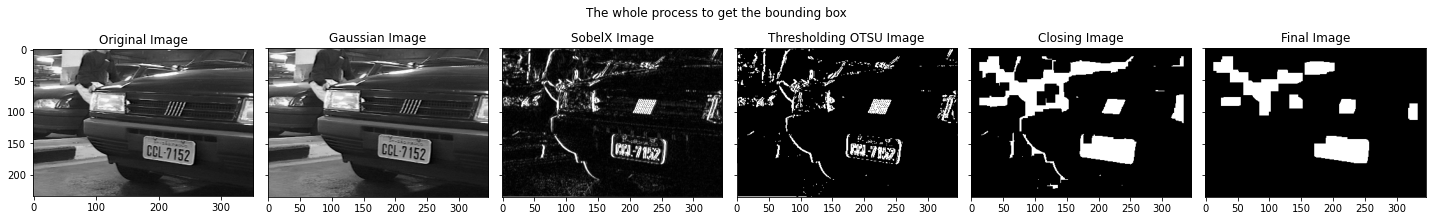

In [585]:
    
img = imageio.imread('placa6.png')
print("Tamño de la image Original: ", img.shape)

# Step1: Gaussian filter:
sigma = 1/(2*pi)
img_gaussian = gaussian_filter(img, 7, sigma)
print("Tamño de la image con filtro Gausiano Pasa bajo: ", img_gaussian.shape)

# Step2: Sobel filter:
img_sobel = Sobel(img_gaussian)
print("Tamño de la image con filtro sobel X: ", img_sobel.shape)

# Step3: Adaptive OTSU+Binary Thresholding:
histogram, bin_edges = np.histogram(img_sobel, bins=256, range=(0, 256))
# Perform Otsu thresholding.
img_otsu = otsu_threshold(img_sobel)
print("Tamño de la image con Threshold OTSU: ", img_otsu.shape)

# Step4: Closing operation:
B = B_nxm(13,13)
#print(B.shape)
img_close = Closing(img_otsu , B)
print("Tamño de la image despues del Closing: ", img_close.shape)

# Step5: Final image
output = Erosion(img_close , B)
img_final = Dilatacion(output , B)
print("Tamño de la image final: ", img_close.shape)

    
#Create two subplots and unpack the output array immediately
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, sharey=True, figsize=(20, 3))
f.suptitle('The whole process to get the bounding box')
ax1.imshow(img, cmap="gray")
ax1.set_title('Original Image')
ax2.imshow(img_gaussian, cmap="gray")
ax2.set_title('Gaussian Image')
ax3.imshow(img_sobel, cmap="gray")
ax3.set_title('SobelX Image')
ax4.imshow(img_otsu, cmap="gray")
ax4.set_title('Thresholding OTSU Image')
ax5.imshow(img_close, cmap="gray")
ax5.set_title('Closing Image')
ax6.imshow(img_final, cmap="gray")
ax6.set_title('Final Image')

#plt.imshow(img1_gray, cmap="gray") # cmap: color mapping
plt.show()



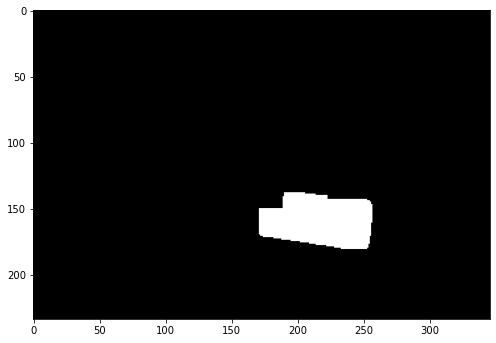

In [586]:
# Imagen Mascara Final de una imagen

for i in range(img_final.shape[0]//2):
    for j in range(img_final.shape[1]):
        img_final[i][j] = 0

plt.imshow(img_final, cmap="gray")  

## Generacion del Dataset Placa y Fondo

In [8]:
#Database BD2 description:
#./BD2/conjunto de datos
#./BD2/placas

#Setting print options with threshold = 0 (For not see any parameter during print command execution)
#np.set_printoptions(threshold=0)

route_mask = './BD2/placas/mask_'
route_auto_mask = './BD2/placas_automask/automask_'
route_imagen = './BD2/placas/orig_'
route_text_train = './BD2/conjunto de datos/entrenamiento'
#route_text_test = './BD2/

route_results_train_text =  './BD2/results/text/entrenamiento'
route_results_train_imagePlaca =  './BD2/results/imagePlaca/'
route_results_train_imageFondo =  './BD2/results/imageFondo/'


#img = imageio.imread(route_mask+'0077.png')
#print(img.shape)

#plt.imshow(img)
#plt.show()


In [603]:
# Experimento 1:
ex = 1
# route_text_train = './BD2/conjunto de datos/entrenamiento'
ent_a = np.loadtxt(route_text_train+str(ex)+'.txt',dtype=str)
ent_a[3:5]

array(['./placas/orig_0013.png', './placas/orig_0017.png'], dtype='<U22')

In [605]:
## Loop throgh all orignal images for create automatic mask

# Creando subimagenes de placas y de fondo de tamaño (H+4) x (W+4) solo para el entrenamiento
ex = 1
# route_text_train = './BD2/conjunto de datos/entrenamiento'
ent_a = np.loadtxt(route_text_train+str(ex)+'.txt',dtype=str)

# route_imagen = './BD2/placas/orig_'
for k, img_nom in enumerate(ent_a):
    img = imageio.imread(route_imagen+img_nom[14:18]+'.png')

    #img = imageio.imread('placa6.png')
    #print("Tamño de la image Original: ", img.shape)
    
    # Step1: Gaussian filter:
    sigma = 1/(2*pi)
    img_gaussian = gaussian_filter(img, 7, sigma)
    #print("Tamño de la image con filtro Gausiano Pasa bajo: ", img_gaussian.shape)
    
    # Step2: Sobel filter:
    img_sobel = Sobel(img_gaussian)
    #print("Tamño de la image con filtro sobel X: ", img_sobel.shape)
    
    # Step3: Adaptive OTSU+Binary Thresholding:
    histogram, bin_edges = np.histogram(img_sobel, bins=256, range=(0, 256))
    # Perform Otsu thresholding.
    img_otsu = otsu_threshold(img_sobel)
    #print("Tamño de la image con Threshold OTSU: ", img_otsu.shape)
    
    # Step4: Closing operation:
    B = B_nxm(13,13)
    #print(B.shape)
    img_close = Closing(img_otsu , B)
    #print("Tamño de la image despues del Closing: ", img_close.shape)
    
    # Step5: Final image
    output = Erosion(img_close , B)
    img_final = Dilatacion(output , B)
    #print("Tamño de la image final: ", img_close.shape)
    
    for i in range(img_final.shape[0]//2):
        for j in range(img_final.shape[1]):
            img_final[i][j] = 0
    
    # Guardando subimagen placa
    # route_auto_mask = './BD2/placas_automask/automask_'
    img_sub_uint8 = img_final.astype(np.uint8)
    imageio.imwrite(route_auto_mask+img_nom[14:18]+'.png',img_sub_uint8)


In [6]:
# Encontrar las coordenadas minimas y maximas del bounding box usando las imagenes mascaras
# nonzero: Return the indices of the elements that are non-zero.
# argmax: Returns the indices of the maximum values along an axis.
# axis = 0: Related to rows
# axis = 1: Related to columns

def coordinatesBBox(image):
    
    pos_unos_x = image.argmax(axis = 0)
    pos_unos_y = image.argmax(axis = 1)

    min_x = np.min(np.nonzero(pos_unos_x))
    max_x = np.max(np.nonzero(pos_unos_x))

    min_y = np.min(np.nonzero(pos_unos_y))
    max_y = np.max(np.nonzero(pos_unos_y))
    
    return min_x, min_y, max_x, max_y


def maxWHCoordinatexBBox(ex):
    """ 
    ex: training number. Values: 1,2,3
    img: imagen
    
    """
    # Load training imagens:
    # Load imagen ids to calculate Width and Height and coordinates according training images of ex training number
    
    # route_text_train = './BD2/conjunto de datos/entrenamiento'
    train_images = np.loadtxt(route_text_train+str(ex)+'.txt',dtype=str)

    # 
    # matrix_results: Image name ID, xmin, ymin, xmax, ymax
    # Matrix definition: [0 for _ in range(5)] for _ in range(train_images.shape[0]) with columns: 5, rows:train_images.shape[0]
    
    matrix_results = np.array([0]*5*train_images.shape[0]).reshape(train_images.shape[0],5)

    # Initialization for Width(W) and Height(H)
    W = 0
    H = 0

    # img_nom[14:18] is the position of imagen ID number
    
    l_min_x = []
    l_min_y = []
    l_max_x = []
    l_max_y = []
    
    for i, img_name in enumerate(train_images):
        # route_mask = './BD2/placas/mask_'
        #img = imageio.imread(route_mask+img_name[14:18] +'.png')
        
        # route_auto_mask = './BD2/placas_automask/automask_'
        img = imageio.imread(route_auto_mask+img_name[14:18] +'.png')
        
        min_x,min_y,max_x,max_y = coordinatesBBox(img)
        # print(min_x,min_y,max_x,max_y)
      
        matrix_results[i][0] = img_name[14:18]
        matrix_results[i][1] = min_x
        matrix_results[i][2] = min_y
        matrix_results[i][3] = max_x
        matrix_results[i][4] = max_y
        
        l_min_x.append(min_x)
        l_min_y.append(min_y)
        l_max_x.append(max_x)
        l_max_y.append(max_y)
        
        #if (abs(max_x-min_x) >= W):
        #    W = abs(max_x-min_x)
        #if (abs(max_y-min_y) >= H):
        #    H = abs(max_y-min_y)
    # route_results_train_text =  './BD2/results/text/entrenamiento'
    np.savetxt(route_results_train_text+str(ex)+'_dat.txt', matrix_results, fmt='%s')
    
    
    df_xy = pd.DataFrame(columns = ["min_x", "min_y", "max_x", "max_y"])
    df_xy["min_x"] = l_min_x
    df_xy["min_y"] = l_min_y
    df_xy["max_x"] = l_max_x
    df_xy["max_y"] = l_max_y
    df_xy["Dif_x"] = np.abs(df_xy["max_x"] - df_xy["min_x"])
    df_xy["Dif_y"] = np.abs(df_xy["max_y"] - df_xy["min_y"])
    W = int(df_xy.mean()["Dif_x"])
    H = int(df_xy.mean()["Dif_y"])
    
    return W, H, df_xy


# Creando subimagenes de placas y de fondo de tamaño (H+4) x (W+4) solo para el entrenamiento

def subImagesFondoPlaca(ex, W, H):
    
    # Now we will do some statistic to W and H for finding the accurate them
    # Find W, H values
    #W, H = maxWHCoordinatexBBox(ex)
    #print("Tamaño de dezplazamiento: ",W,H)
    
    # Loading matrix results: Image name ID, xmin, ymin, xmax, ymax
    # route_results_train_text =  './BD2/results/text/entrenamiento'
    ent_a = np.loadtxt(route_results_train_text + str(ex) +'_dat.txt',dtype=int)
    
    for k, img_nom in enumerate(ent_a):
        # route_imagen = './BD2/placas/orig_'
        img = imageio.imread(route_imagen +'0'*(4-len(str(img_nom[0]))) + str(img_nom[0]) +'.png')
        
        print("Tamaño de la Imagen Original: ", img.shape) 
        
        ###### Cutting placa imagen #########
        min_x = img_nom[1]
        min_y = img_nom[2]
        max_x = img_nom[3]
        max_y = img_nom[4]
        
        # Initializing img_sub with 0s like a matrix:
        # np.zeros is a matrix with H+4 rows and W+4 columns
        img_sub = np.zeros([ H+4 , W+4 ], dtype=int)
        
        print("Tamaño de la Sub-Imagen Placa: ",img_sub.shape)
        
        # Coordinates from which we should start to cut the place image
        # Other option is to start from (min_x, min_y)
        
        # desde_x: it is a row coordenate but we use y part because it is a start from the begin y axis
        # desde_y: it is a column coordenate but we use x part because it is a start from the begin x axis
        # This is like this becasue the element of a matrix is (row, col)
        desde_y = math.floor((min_x+max_x-W)/2)-2
        desde_x = math.floor((min_y+max_y-H)/2)-2
        
        #desde_x = min_x
        #desde_y = min_y
        
        print("Coordinates from where we start to cut: ",desde_x, desde_y)
        
        for i in range(0,H+4):
            for j in range(0,W+4):
                img_sub[i,j] = img[desde_x+i, desde_y+j]
                #print(i,j,desde_x, desde_y,desde_x+i, desde_y+j )
                
        # Saving subimagen placa
        #route_results_train_imagePlaca =  './BD2/results/imagePlaca/'
        imageio.imwrite(route_results_train_imagePlaca +'orig_'+'0'*(4-len(str(img_nom[0])))+str(img_nom[0])+'_placa.png',img_sub)
        
      
        ###### Cutting fondo imagen ##############
        for i in range( 0 , img.shape[0]-H-4, H+4):
            for j in range(0 , img.shape[1]-W-4, W+4):
                if ((i+H+4 <= desde_x and j+W+4 <= img.shape[1]) 
                    or (i+H+4 <= img.shape[0] and j+W+4 <= desde_y)  
                    or (i+H+4 <= img.shape[0] and j > desde_y++W+4)  
                    or ( i+H+4 <= img.shape[0] and i>desde_x++H+4 and j+W+4 <= img.shape[1])):
                    
                    img_sub = np.zeros([ H+4 , W+4 ], dtype=int)
                    
                    print()
                    print("Tamaño de la Sub-Imagen Fondo: ",img_sub.shape)
                    
                    for m in range(i, H+4+i):
                        for n in range(j, W+4+j):
                            img_sub[m-i,n-j] = img[m,n]
                    
                    # Saving subimagen fondo
                    # route_results_train_imageFondo =  './BD2/results/imageFondo/'
                    imageio.imwrite(route_results_train_imageFondo +'orig_'+'0'*(4-len(str(img_nom[0])))+str(img_nom[0])+'_'+str(i)+'_'+str(j)+'_fondo.png',img_sub)
    
    
        
        

In [9]:
# Find W, H values
W, H, df_xy = maxWHCoordinatexBBox(1)
print(W, H)

177 52


In [ ]:
# Find W, H values
W, H, df_xy = maxWHCoordinatexBBox(1)

print("Tamaño de dezplazamiento: ",W,H)

# Se generaron Sub imagenes de W=127 y H =52

subImagesFondoPlaca(1, W-50, H)

In [760]:
df_xy.describe()

,min_x,min_y,max_x,max_y,Dif_x,Dif_y
count,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,101.33000,122.760000,278.710000,175.370000,177.380000,52.610000
std,44.84047,10.104624,50.291734,13.486735,70.166149,16.693248
min,13.00000,117.000000,84.000000,149.000000,67.000000,26.000000
25%,67.75000,117.000000,246.750000,166.750000,101.750000,39.000000
50%,86.50000,117.000000,280.500000,174.000000,185.000000,50.000000
75%,144.25000,125.000000,329.250000,183.250000,236.500000,64.000000
max,213.00000,157.000000,332.000000,214.000000,298.000000,97.000000


In [732]:
df_xy.mean()["Dif_x"]


177.38

## Analisis Estadistico

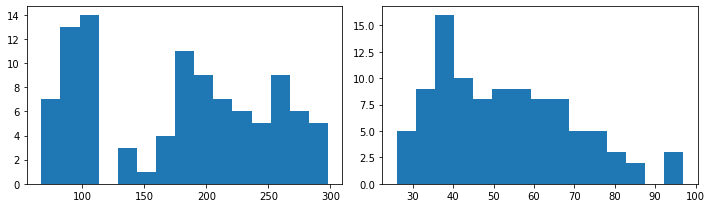

In [749]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))
ax1.hist(df_xy["Dif_x"], bins = 15)
ax2.hist(df_xy["Dif_y"], bins = 15)
plt.show()

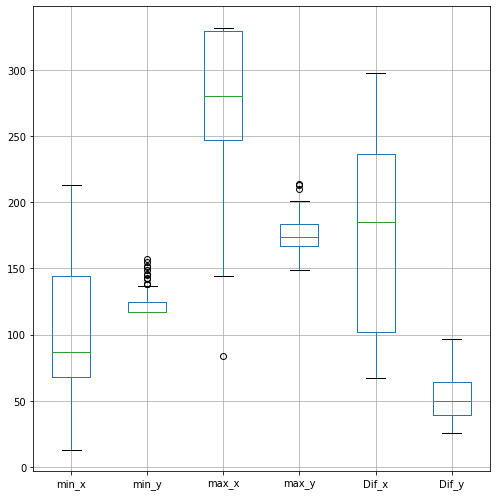

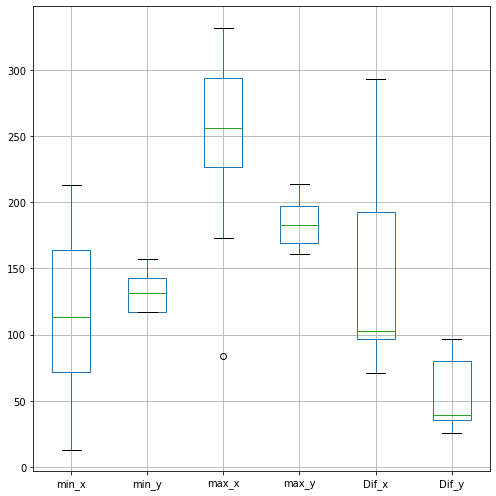

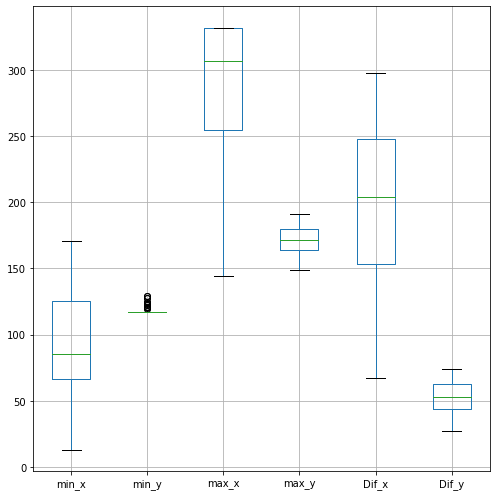

In [758]:
# Calculate 1st and 3rd percentiles, and IQR
Q0 = df_xy.quantile(0.05)
Q1 = df_xy.quantile(0.15)
Q2 = df_xy.quantile(0.50)
Q3 = df_xy.quantile(0.75)
Q4 = df_xy.quantile(1.00)
    
#print(Q0, Q1, Q2, Q3, Q4)
IQR= Q3 - Q1
#sys.exit(0)

# Filter out the rows that fall outside the 1.5 threshold in each column
filtro = ((df_xy < (Q1 - 1.5 * IQR)) | (df_xy > (Q3 + 0.5 * IQR))).any(axis=1)
df_xy_outliers    = df_xy[filtro]
df_xy_new = df_xy[~filtro]


df_xy.boxplot()
plt.show()
df_xy_outliers.boxplot()
plt.show()
df_xy_new.boxplot()
plt.show()

In [759]:
df_xy_new.describe()

,min_x,min_y,max_x,max_y,Dif_x,Dif_y
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.00000
mean,96.200000,118.514286,288.428571,171.714286,192.228571,53.20000
std,39.258194,3.206618,44.272729,10.897604,65.214734,12.43837
min,13.000000,117.000000,144.000000,149.000000,67.000000,27.00000
25%,66.250000,117.000000,254.250000,164.250000,153.500000,44.00000
50%,85.000000,117.000000,306.500000,171.500000,204.000000,53.00000
75%,125.750000,117.000000,332.000000,180.000000,247.750000,63.00000
max,171.000000,129.000000,332.000000,191.000000,298.000000,74.00000


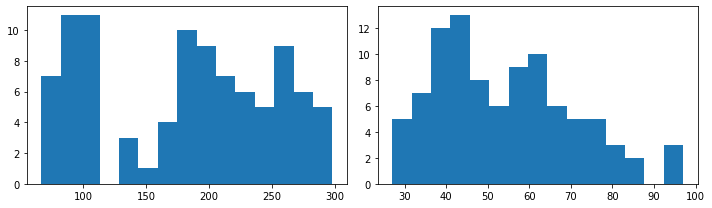

In [755]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))
ax1.hist(dataset_new["Dif_x"], bins = 15)
ax2.hist(dataset_new["Dif_y"], bins = 15)
plt.show()

# 2. ENTRENAMIENTO

In [41]:
# 1. LBP Algorithm

def algLBPnxn(image, n):
    """
    n: odd number(impar), n=3,5,6,9,11,...
    
    """
    #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # imgLBP: matrix of descriptor after applying comparinson by threshold    
    imgLBP = np.zeros_like(image)
    neighboor = n 
    num = 0
    for ih in range(0,image.shape[0]-2):
        for iw in range(0,image.shape[1]-2):
            
            ### Step 1: Obtain binary vector from n by n pixel matrix
            img_nxn = image[ih:ih+neighboor,iw:iw+neighboor]
            #center = img_nxn[(n+1)*(n-1)/2 ,(n+1)*(n-1)/2]
            center = img_nxn[1,1]
            img_binanry_matrix = (img_nxn >= center)*1.0
            
            # Also we can order in anti-counterclock way: img01_vector = img01.T.flatten()
            # Deleting 
            img_binanry_vector = np.delete(img_binanry_matrix.flatten(),n+1)
            
            ### Step 2: Convert binary to Decimal
            # If there is somthing to convert
            img_binanry_vector_index = np.where(img_binanry_vector)[0]
            
            if len(img_binanry_vector_index) >= 1:
                img_des = np.sum(2**img_binanry_vector_index)
            else:
                img_des = 0
                
            imgLBP[ih+1,iw+1] = img_des
            
    return imgLBP


def algDesToFrec(img, n):
    des = algLBPnxn(img, n)
    # aplanando des previo para calculo de frecuencia, tiene 126 x 126 = 15876 dimensiones
    des_flatted = [item for sublist in des for item in sublist]
    # print("des plano =", des_fla)
    
    # calculando frecuencia para aplicar reduccion dimensional a 2^8 = 256 dimensiones
    dic_fre_des = {}
    for i in des_flatted:
        if i in dic_fre_des:
            dic_fre_des[i] += 1
        else:
            dic_fre_des[i] = 1
  
    return dic_fre_des


In [799]:
# 3. Calculating description and frecuency for all images placa and images fondo

##### Calculo de LBP para las imagenes Placa
# numero de dimensiones del descriptor para cada imagen (entre 1 y 256 y potencia de 2)
num_dimensiones = 128


route_results_train_text_results =  './BD2/results/text/'
route_results_train_text =  './BD2/results/text/entrenamiento'
route_results_train_imagePlaca =  './BD2/results/imagePlaca/'
route_results_train_imageFondo =  './BD2/results/imageFondo/'

ent_a = np.loadtxt(route_results_train_text+str(ex)+'_dat.txt',dtype=int)

ent = np.zeros([ent_a.shape[0], num_dimensiones], dtype=int)

print(ent.shape)

for k, img_nom in enumerate(ent_a):

    img = imageio.imread(route_results_train_imagePlaca+'orig_'+'0'*(4-len(str(img_nom[0])))+str(img_nom[0])+'_placa.png')
  
    # Inicializa la matriz de descriptores con valores cero
    # Aplica el algoritmo LBP, devuelve la matriz des con valores binarios
    # Convierte la matriz des a valores decimales
    # Aplana des para prepararla para calculo de frecuencia, des tiene (img.shape[0]-2) x (img.shape[1]-2) dimensiones
    # Calculando frecuencia para aplicar reduccion dimensional a 2^8 = 256 dimensiones, devuelve free_des_fla
    dic_fre_des = algDesToFrec(img,3)
 
    intervalos = 256 // num_dimensiones
    
    for valor in sorted(dic_fre_des):
        # PARTE 1
        # Punto 5: Cálculo del descriptor en función a resultados del histograma
        # guardando dato de entrenamiento (las frecuencias)
        for posi in range(num_dimensiones):
            if valor <= intervalos*(posi+1)-1:
                break
    
        ent[k,posi] =  ent[k,posi] + dic_fre_des[valor]
    #print(ent[k,posi])
    
    # Guardando datos resultado de entrenamiento en archivo externo para uso en proceso de clasificación
np.savetxt(route_results_train_text_results+'Project4_Mejorado'+str(num_dimensiones)+'d_placa.txt', ent, fmt='%d')


(100, 128)


In [802]:


##### Calculo de LBP para las imagenes Fondo
# numero de dimensiones del descriptor para cada imagen (entre 1 y 256 y potencia de 2)
num_dimensiones = 128

route_results_train_text_results =  './BD2/results/text/'
route_results_train_text =  './BD2/results/text/entrenamiento'
route_results_train_imagePlaca =  './BD2/results/imagePlaca/'
route_results_train_imageFondo =  './BD2/results/imageFondo/'


contenido = glob(route_results_train_imageFondo+'*.png')
print("Num imagenes fondo para entrenamiento =", len(contenido))

# inicializando matriz para resultados del entrenamiento: clases fondo, contiene len(contenido) imagenes,
# cada imagen contiene un vector descriptor de num_dimensiones
ent = np.zeros([len(contenido), num_dimensiones], dtype=int)
print(ent.shape)
print("")


for k, img_nom in enumerate(contenido):

    img = imageio.imread(img_nom)
    
    # Inicializa la matriz de descriptores con valores cero
    # Aplica el algoritmo LBP, devuelve la matriz des con valores binarios
    # Convierte la matriz des a valores decimales
    # Aplana des para prepararla para calculo de frecuencia, des tiene (img.shape[0]-2) x (img.shape[1]-2) dimensiones
    # Calculando frecuencia para aplicar reduccion dimensional a 2^8 = 256 dimensiones, devuelve free_des_fla
    dic_fre_des = algDesToFrec(img,3)

    intervalos = 256 // num_dimensiones
    
    for valor in sorted(dic_fre_des):
        # PARTE 1
        # Punto 5: Cálculo del descriptor en función a resultados del histograma
        # guardando dato de entrenamiento (las frecuencias)
        for posi in range(num_dimensiones):
            if valor <= intervalos*(posi+1)-1:
                break
    
        ent[k,posi] =  ent[k,posi] + dic_fre_des[valor]

    
    # Guardando datos resultado de entrenamiento en archivo externo para uso en proceso de clasificación
np.savetxt(route_results_train_text_results+'Project4_Mejorado'+str(num_dimensiones)+'d_fondo.txt', ent, fmt='%d')


Num imagenes fondo para entrenamiento = 504
(504, 128)



# 3. EVALUACION Y EVALUACION

In [52]:
# Cargando parametros generales realizado en el entrenamiento

num_dimensiones = 128

route_mask = './BD2/placas/mask_'
route_auto_mask = './BD2/placas_automask/automask_'
route_imagen = './BD2/placas/orig_'
route_text_train = './BD2/conjunto de datos/entrenamiento'
route_text_test = './BD2/conjunto de datos/prueba'

route_results_train_text =  './BD2/results/text/entrenamiento'
route_results_train_imagePlaca =  './BD2/results/imagePlaca/'
route_results_train_imageFondo =  './BD2/results/imageFondo/'
route_results_train =  './BD2/results/text/'


route_results_test =  './BD2/results/detection/'

# Cargando datos resultado de entrenamiento en archivo externo para uso en proceso de clasificación
ent_arr_p = np.loadtxt(route_results_train_text_results+'Project4_Mejorado'+str(num_dimensiones)+'d_placa.txt')
ent_arr_f = np.loadtxt(route_results_train_text_results+'Project4_Mejorado'+str(num_dimensiones)+'d_fondo.txt')

umbral = 50
VP = 0
FP = 0
FN = 0
VN = 0

W= 127
H= 52
print(ent_arr_p.shape)
print(ent_arr_f.shape)
print(W,H)

(100, 128)
(504, 128)
127 52


In [53]:
# Parametros para la evaluacion y deteccion de placas

contenido = glob(route_auto_mask+'*.png')
contenido.sort()
print("Num imagenes totales =", len(contenido))

# inicializando matriz que contendra parametros de posicion verdadera de placas en imagenes que se usaran para detrminar
# valores de matriz de confusión
par = [[0 for _ in range(3)] for _ in range( len(contenido) )]  

for i, img_nom in enumerate(contenido):
  img = imageio.imread(img_nom)
  min_x_v,min_y_v,_,_ = coordinatesBBox(img)
  par[i][0] = img_nom[-8:-4]
  par[i][1] = min_x_v
  par[i][2] = min_y_v

np.savetxt(route_results_train+'proc_total_coordenadas_placas_verdaderas.txt', par, fmt='%s')
par_arr = np.array(par)

Num imagenes totales = 100


In [49]:
!ls

 automask_000..png	 placa4.png
 BD2			 placa5.png
 Design_20220710.odg	 placa6.png
 ImageOperations.ipynb	 placa7.png
 Information		 placa8.png
 lena.jpg		 placa9.png
 pajaritos2.jpg		 Project4_notes.md
 pajaritos.jpeg		'Projecto 1 - LBP + KNN.odt'
 placa10.png		 Proyecto4_Final.ipynb
 placa1.jpg		 Proyecto4_working.ipynb
 placa1.png		 ReporteFinal_Draft
 placa2.jpg		 Week7_ImageOperations_tarea_week6_Miguel_mio.ipynb
 placa3.jpg


## DETECTION

In [56]:


# Creando en memoria subimagenes (de cada imagen de prueba) de tamaño (H+4) x (W+4)
detectection_results = []

ex = 1
det_a = np.loadtxt(route_text_test+str(ex)+'.txt',dtype=str)
print("Imagenes a procesar ",det_a.shape[0])

for k, img_nom in enumerate(det_a):
  
    img = imageio.imread(route_imagen+img_nom[14:18]+'.png')
  
    dist_p_min_t = 9999 # Distancia min total a clase placa de sub imagen
    i_p_min_t, j_p_min_t = 0, 0 # Coordenadas de inicio de mejor sub imagen detectado como placa
    placa_encontrada = False
  
    print("*"*20)
    print("Detectando placa en ",img_nom)
    print("*"*20)
   
  
    # Creando subimagenes en memoria
    for i in range( 0 , img.shape[0]-H-4, 61):
      for j in range(0 , img.shape[1]-W-4, 29):
      
        if ( i+H+4 <= img.shape[0] and j+W+4 <= img.shape[1] ):
  
          img_sub = np.zeros([ H+4 , W+4 ], dtype=int)
          for m in range(i, H+4+i):
            for n in range(j, W+4+j):
              img_sub[m-i,n-j] = img[m,n]
  
          # inicializando matriz de resultados para guardar los descriptores de esta sub imagen
          cla = np.zeros([num_dimensiones], dtype=int)
  
          # Inicializa la matriz de descriptores con valores cero
          # Aplica el algoritmo LBP, devuelve la matriz des con valores binarios
          # Convierte la matriz des a valores decimales
          # Aplana des para prepararla para calculo de frecuencia
          # Calculando frecuencia para aplicar reduccion dimensional a 2^8 = 256 dimensiones, devuelve free_des_fla
          fre_des_fla = algDesToFrec(img_sub,3)
  
          intervalos = 256 // num_dimensiones
          for valor in sorted(fre_des_fla):
            # guardando dato de entrenamiento (las frecuencias)
            for posi in range(num_dimensiones):
              if valor <= intervalos*(posi+1)-1:
                break
            cla[posi] = cla[posi] + fre_des_fla[valor]
  
  
          # Cálculo de distancia euclidiana entre vector descriptor de sub imagen analizada y cada vector descriptor del entrenamiento
          # ALGORITMO DE DISTANCIA
  
          # Inicializando matriz de distancias a placa
          dist_p = np.zeros([ent_arr_p.shape[0]])
          # Calculando matriz de distancias
          for s in range(dist_p.shape[0]): 
              dist_p[s] = np.linalg.norm(cla - ent_arr_p[s])
  
          # Inicializando matriz de distancias a fondo
          dist_f = np.zeros([ent_arr_f.shape[0]])
          # Calculando matriz de distancias
          for s in range(dist_f.shape[0]): 
              dist_f[s] = np.linalg.norm(cla - ent_arr_f[s])
  
  
          # Identificación si la sub imagen es de clase placa por menor distancia
          dist_p_min = dist_p.min()
          dist_f_min = dist_f.min()
  
          #print()
          #print("distancia a placa =",dist_p_min, "distancia a fondo=", dist_f_min)
          detectection_results.append(["distancia a placa =",dist_p_min, "distancia a fondo=", dist_f_min])
                                       
          if (dist_p_min < dist_f_min): # Encontre sub imagen placa
            placa_encontrada = True
            print('Placa detectada: orig_'+img_nom[14:18]+'_'+str(i)+'_'+str(j)+'_placa_det.png')
            detectection_results.append('Placa detectada: orig_'+img_nom[14:18]+'_'+str(i)+'_'+str(j)+'_placa_det.png')                   
            # solo guardo sub_img solo para chequeo, debo de pintar rec en imagen ori
            img_sub_uint8 = img_sub.astype(np.uint8)
            imageio.imwrite(route_results_test+'orig_'+img_nom[14:18]+'_'+str(i)+'_'+str(j)+'_placa_det.png',img_sub_uint8)
  
            if (dist_p_min <= dist_p_min_t): # Busco la mejor placa por minima distancia entre las placas detectadas
              dist_p_min_t = dist_p_min
              i_p_min_t = i
              j_p_min_t = j
  
          else:
            #print('Fondo detectado: orig_'+img_nom[14:18]+'_'+str(i)+'_'+str(j)+'_fondo_det.png')
            detectection_results.append('Fondo detectado: orig_'+img_nom[14:18]+'_'+str(i)+'_'+str(j)+'_fondo_det.png')
            # solo guardo sub_img solo para chequeo, debo de pintar rec en imagen ori
            img_sub_uint8 = img_sub.astype(np.uint8)
            imageio.imwrite(route_results_test+'orig_'+img_nom[14:18]+'_'+str(i)+'_'+str(j)+'_fondo_det.png',img_sub_uint8)
  
  
  
            # *** Solo para calculo FN o VN
            dist = np.sqrt( (min_x_v - i)**2 + (min_y_v - j)**2 )
            if (dist<=umbral): # Fondo detectado como placa
              FN += 1
            else:
              VN += 1
            # *** Fin solo para calculo FN o VN
  
  
  
    if (placa_encontrada):
      color_pintar = 255
  
  
      # *** Solo para calculo VP o FP
      dist = np.sqrt( (min_x_v - i_p_min_t)**2 + (min_y_v - j_p_min_t)**2 )
      if (dist<=umbral):
        VP += 1
        color_pintar = 255
      else:
        FP += 1
        color_pintar = 0
      # *** Fin solo para calculo VP o FP
  
  
  
      # Dibujo rectangulo de placa encontrada sobre imagen original
      # Linea horizontal arriba
      for n in range(j_p_min_t, W+4+j_p_min_t):
        img[i_p_min_t,n] = color_pintar
      # Linea horizontal abajo
      for n in range(j_p_min_t, W+4+j_p_min_t):
        img[H+4+i_p_min_t,n] = color_pintar
      # Linea vertical izquierda
      for m in range(i_p_min_t, H+4+i_p_min_t):
        img[m,j_p_min_t] = color_pintar
      # Linea vertical derecha
      for m in range(i_p_min_t, H+4+i_p_min_t+1):
        img[m,W+4+j_p_min_t] = color_pintar
  
      img_uint8 = img.astype(np.uint8)
      imageio.imwrite(route_results_test+'orig_'+img_nom[14:18]+'_'+str(i_p_min_t)+'_'+str(j_p_min_t)+'.png',img_uint8)
    else:
      FN += 1
  
    print()
    
np.savetxt(route_results_train+'detectection_results', detectection_results, fmt='%s')

Imagenes a procesar  100
********************
Detectando placa en  ./placas/orig_0001.png
********************
Placa detectada: orig_0001_61_203_placa_det.png
Placa detectada: orig_0001_122_58_placa_det.png
Placa detectada: orig_0001_122_87_placa_det.png
Placa detectada: orig_0001_122_116_placa_det.png

********************
Detectando placa en  ./placas/orig_0002.png
********************
Placa detectada: orig_0002_61_58_placa_det.png
Placa detectada: orig_0002_61_87_placa_det.png
Placa detectada: orig_0002_61_116_placa_det.png
Placa detectada: orig_0002_61_145_placa_det.png
Placa detectada: orig_0002_122_29_placa_det.png
Placa detectada: orig_0002_122_58_placa_det.png
Placa detectada: orig_0002_122_87_placa_det.png
Placa detectada: orig_0002_122_116_placa_det.png
Placa detectada: orig_0002_122_145_placa_det.png
Placa detectada: orig_0002_122_174_placa_det.png
Placa detectada: orig_0002_183_174_placa_det.png
Placa detectada: orig_0002_183_203_placa_det.png

********************
Detectan

## EVALUCION

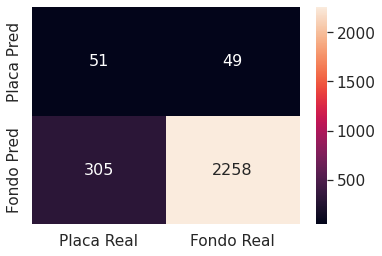

In [48]:
# Evaluacion

# Matriz de confusión

array = [[VP,FP],
         [FN,VN]]

df_cm = pd.DataFrame(array, index=["Placa Pred", "Fondo Pred"], columns=["Placa Real", "Fondo Real"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

plt.show()

In [60]:
# Presicion y Accurracy y 
Presicion = VP/(VP+FP)
Accurracy = (VN+VP)/(VN+VP+FP+FN)*100

# Coeficiente de kappa de cohen 

Pr_ = (VP+VN)/(VN+VP+FP+FN)
Pe_ = (VP+FP)/(VN+VP+FP+FN)*(VP+FN)/(VN+VP+FP+FN) + (FN+VN)/(VN+VP+FP+FN)*(FP+VN)/(VN+VP+FP+FN)

Co_Ka = (Pr_ - Pe_)/(1- Pe_)

print("Evaluacion del Modelo usando ", num_dimensiones, "dimensiones")
print("=============================================================")
print("PRESICION -> La calidad del modelo es: ", Presicion)
print("ACURACCY -> % casos que el modelo acertó: ", Accurracy)
print("COEF. COHEN -> Se puede entender que el grado de concordancia es de: ", Co_Ka)

Evaluacion del Modelo usando  128 dimensiones
PRESICION -> La calidad del modelo es:  0.5433070866141733
ACURACCY -> % casos que el modelo acertó:  86.81738109219025
COEF. COHEN -> Se puede entender que el grado de concordancia es de:  0.1876182614229509
